In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [2]:
segment_directory = "segmentation.csv"

segment = pd.read_csv(segment_directory, header=0 )

In [3]:
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194


# Подготовка исходных данных
1. Необходимо привести все данные к числовым типам. 

В столбце Recency записана дата в формате str. Преобразуем данные в этом столбце так, чтобы значения отображали количество дней прошедших с даты покупки до конца периода. Конец периода - максимальное значение даты в столбце Recency.
2. Нормализация данных.

Параметры покупок имеют разный порядок величин, что может привести к неточностям при обработке данных, т.к. методы обработки данных, которые буду использованы далее, чувствительны к масштабу величин.
Поэтому значения в каждом столбце заменим на их отношение к максимальному значению в столбце.

In [4]:
segment['Recency'] = pd.to_datetime(segment['Recency'])
max_date = segment['Recency'].max()
segment['Recency'] = segment['Recency'].apply(lambda x: (max_date-x).days)

segment.loc[:7,:]

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,12,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,22,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,22,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,88,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,67,5,0.51,0.44,0.912099,0.206194
5,f8b731d8-0915-4b23-a940-821aa9d8a672,63.00,107,1,0.07,0.15,0.149634,0.397851
6,60d50ae8-736d-462a-a483-cd634bff9b4f,200.00,8,2,1.00,0.77,0.503883,0.975136
7,7fcfb932-1360-46da-9c78-6e20473e0b58,6.99,118,1,0.15,0.66,0.194148,0.906759


In [5]:
seg = segment[['Monetary', 'Recency', 'Frequency', 'factor_1', 'factor_2', 'factor_3', 'factor_4']]
seg.head()

,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,100.40,12,6,0.35,0.08,0.609740,0.949383
1,170.00,22,4,0.66,0.16,0.942272,0.479846
2,70.75,22,6,0.92,0.20,0.323030,0.007076
3,75.00,88,10,0.35,0.78,0.876833,0.088974
4,94.51,67,5,0.51,0.44,0.912099,0.206194


In [6]:
for factor in list(seg):
    max_value = seg[factor].max()
    seg[factor] = seg[factor].apply(lambda x: x/max_value)
seg.head()

C:\Users\HomePC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,0.033026,0.072289,0.054054,0.35,0.08,0.609742,0.949437
1,0.055921,0.132530,0.036036,0.66,0.16,0.942276,0.479873
2,0.023273,0.132530,0.054054,0.92,0.20,0.323032,0.007076
3,0.024671,0.530120,0.090090,0.35,0.78,0.876836,0.088979
4,0.031089,0.403614,0.045045,0.51,0.44,0.912103,0.206205


# Метод главных компонент (PCA)
Метод позволяет уменьшить размерность пространства данных. В данном случае приведем простраство к трехмерному и визуализируем расположение точек.

In [7]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(seg.values)
seg['pca-one'] = pca_result[:,0]
seg['pca-two'] = pca_result[:,1] 
seg['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.21942921 0.19627939 0.19285506]


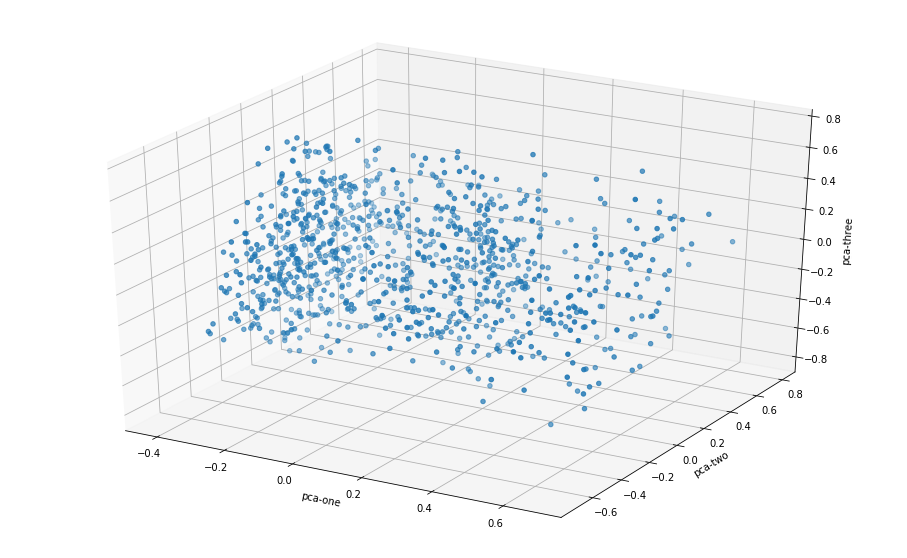

In [8]:
rndperm = list(range(1,1000))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=seg.loc[rndperm,:]["pca-one"], 
    ys=seg.loc[rndperm,:]["pca-two"], 
    zs=seg.loc[rndperm,:]["pca-three"], 

    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Разделение на кластеры
Для разделения данных воспользуемся методом k-средних (k-means), который позволяет определить центры кластеров, путем минимизации суммарного квадратичного отклонения точек кластера от его центров.

Text(0, 0.5, '$J(C_k)$')

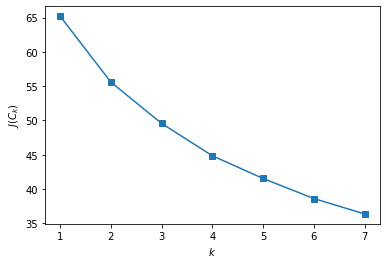

In [9]:
clusters = {}
cluster_data = pd.DataFrame(seg[['pca-one', 'pca-two', 'pca-three']])
   
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(cluster_data)
    inertia.append(np.sqrt(kmeans.inertia_))
    predict = kmeans.predict(cluster_data)
    clusters[k] = predict
    

plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')    

Критерий $J(C_k)$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся. Необходимо выбрать $k$, при котором функционал $J(C_k)$ падает не так быстро. В данном случае снижение критерия достаточно плавно для всех выбранных значений, т.е. можно предположить, что допустимо было бы выбрать $k$ от 2 до 6.
Выберем $k$=3.

In [10]:
cluster_data['cluster'] = clusters[3]
cluster_data.loc[:10,:]

,pca-one,pca-two,pca-three,cluster
0,-0.254233,-0.027137,-0.374837,0
1,-0.155866,-0.268026,0.165689,0
2,-0.194373,-0.682952,0.185667,0
3,0.191138,0.175957,0.348905,1
4,0.094626,-0.100023,0.267664,2
5,0.278196,-0.126349,-0.601603,2
6,-0.323112,0.142039,0.332154,1
7,0.303280,0.438717,-0.422282,2
8,-0.165251,0.531147,-0.041744,1
9,0.172056,0.114444,-0.490027,2


C:\Users\HomePC\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\HomePC\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


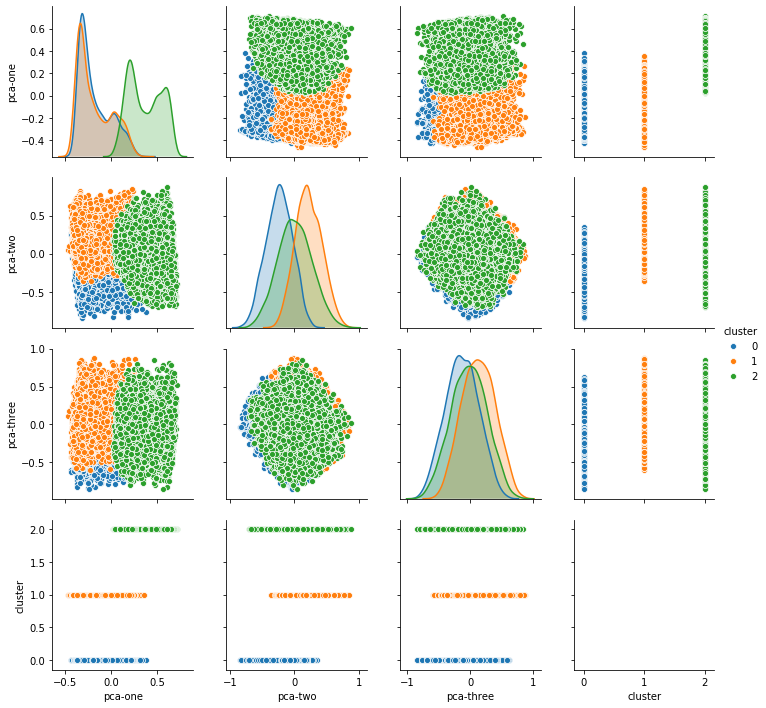

In [11]:
sns.pairplot(cluster_data[['pca-one', 'pca-two', 'pca-three', 'cluster']], hue = 'cluster')

# Отбор признаков и анализ кластеров
Выберем те признаки, которые лучшим образом будут характеризовать ранее обозначенные кластеры. Ограничимся 3мя признаками из  7ми имеющихся в начальном наборе данных.

Сначала воспользуемся одномерным методом отбора с использованием критерия xi-квадрат. В качестве целевой переменной используем номер кластера (cluster). В результате получим оценки для каждого признака - чем выше оценка, тем более выраженную связь имеет признак с целевой переменной. Три самые высокие оценки имеют признаки Recency, factor_2 и factor_3

In [12]:
seg['cluster'] = clusters[3]
array = seg[['Monetary', 'Recency', 'Frequency', 'factor_1', 'factor_2', 'factor_3', 'factor_4','cluster']].values

X = array[:,0:7].astype('float')

Y = array[:,7].astype('int64')

test = SelectKBest(score_func=chi2, k=3)

fit = test.fit(X, Y)

np.set_printoptions(precision=3)

print(fit.scores_)

features = fit.transform(X)

print(features[0:8,:])

[  53.258 2907.794   41.745   15.649 1286.749  167.436   68.448]
[[0.072 0.08  0.61 ]
 [0.133 0.16  0.942]
 [0.133 0.2   0.323]
 [0.53  0.78  0.877]
 [0.404 0.44  0.912]
 [0.645 0.15  0.15 ]
 [0.048 0.77  0.504]
 [0.711 0.66  0.194]]


Также можно воспользоваться методом рекурсивного исключения признаков (RFE). В результате отобранные признаки помечены значением true в массиве support_ и значением 1 в массиве ranking_. Получаем аналогичный результат - были отобраны признаки Recency, factor_2 и factor_3

In [13]:
model = LogisticRegression()

rfe = RFE(model, 3)

fit = rfe.fit(X, Y)

print( fit.n_features_)

print( fit.support_)

print( fit.ranking_)

C:\Users\HomePC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HomePC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\HomePC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HomePC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\HomePC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defau

3
[False  True False False  True  True False]
[4 1 5 3 1 1 2]


C:\Users\HomePC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Вернемся к начальному набору данных и найдем средние значения признаков для каждого из трех кластеров и визуализируем их в проекциях Recency, factor_2 и factor_3.

In [14]:
segment['cluster'] = clusters[3]

for factor in ['Monetary', 'Recency', 'Frequency', 'factor_1', 'factor_2', 'factor_3', 'factor_4']:
    print(factor)
    for n in range(0,3):
        seg_clust = segment.loc[segment['cluster'] == n]
        print('cluster', n+1,' ',seg_clust[factor].mean())
    print('\n')

Monetary
cluster 1   157.93156782039256
cluster 2   152.3234232250964
cluster 3   77.84339162182937


Recency
cluster 1   27.94087932647334
cluster 2   31.298477343606677
cluster 3   119.55630284396618


Frequency
cluster 1   4.767259120673526
cluster 2   4.618418638781875
cluster 3   2.412567255956956


factor_1
cluster 1   0.5299139382600578
cluster 2   0.4773968079251518
cluster 3   0.49297655649500327


factor_2
cluster 1   0.2643143124415318
cluster 2   0.7498312236286865
cluster 3   0.47381437355880085


factor_3
cluster 1   0.3989381982519297
cluster 2   0.5709611508510881
cluster 3   0.5154837174607584


factor_4
cluster 1   0.4426170428861119
cluster 2   0.5550011804146799
cluster 3   0.496489435724115




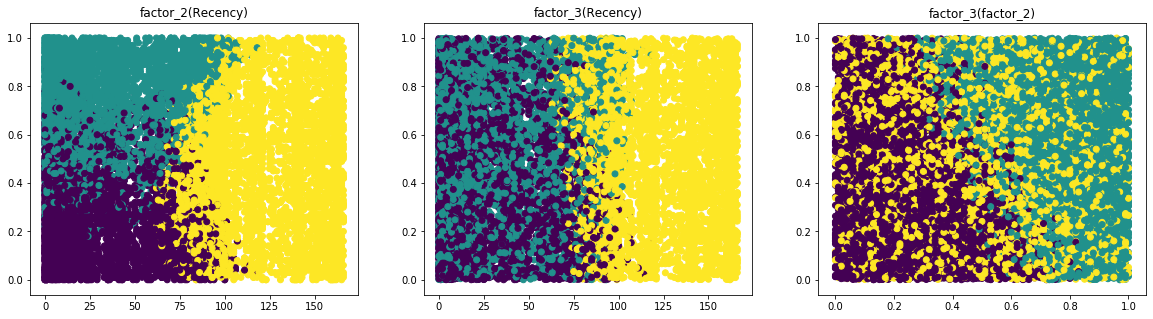

In [15]:
x_axis = segment['Recency']
y_axis = segment['factor_2']
z_axis = segment['factor_3']
 
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(131)
ax1.set(title='factor_2(Recency)')
ax1.scatter(x_axis, y_axis, c=segment['cluster'])

ax2 = fig.add_subplot(132)
ax2.set(title='factor_3(Recency)')
ax2.scatter(x_axis, z_axis, c=segment['cluster'])

ax3 = fig.add_subplot(133)
ax3.set(title='factor_3(factor_2)')
ax3.scatter(y_axis, z_axis, c=segment['cluster'])

plt.show()

Наиболее четкую картину разделения на кластеры можно наблюдать на проекции по признакам Recency и factor_2, т.е. можно назвать эти признаками определяющими для кластеров.

# Описание кластеров
Обратимся к средним значениям признаков, которые были получены ранее для кажого выделенного кластера.

Одним из определяющих признаков, как мы выяснили ранее, является признак Recency. Кластер 3 имеет самое большое и значительно отличающееся среднее значение признака в сравнеии с кластерами 1 и 2, у которых эти значения примерно одинаковы. Также средние значения признаков Monetary и Frequency для кластера 3 меньше со схожими между собой значеними у кластеров 1 и 2. 

Т.е. кластер 3 определяет категорию клиентов, которые были активны в начале периода, редко совершали покупки и тратили на них небольшое количество средств. Вероятно, это клиенты, которые впервые решили воспользоваться услугами торговой площадки  и более не возвращались к покупкам. Эту группу клиентов можно назвать "незаинтересованными новичками".

Как уже отметили чуть ранее, кластеры 1 и 2 имеют схожие среднии значения признаков Monetary, Recency и Frequency. Судя по их значениям, можно предполужить, что эти категории клиентов были одинаково активны на протяжении всего периода. Чтобы найти отличия обратимся к средним значениям скрытых признаков. Значения признаков factor_1 и factor_4 примерно одинаковы для всех трех кластеров. Отличия наблюдаются в значениях признаков factor_2 и factor_3: разница составляет почти 3 и 1.5 раза соответственно для кластеров 1 и 2. Суть этих отличий неудается определить, т.к. неизвестен смысл скрытых признаков.